[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO11 Object Detection on a Custom Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sun Jan 19 15:50:39 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!rm -rf {HOME}/datasets
!rm -rf {HOME}/runs/detect/predict*
!rm -rf {HOME}/runs/detect/train*
!rm -rf {HOME}/runs/detect/val*


**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [4]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 31.1/112.6 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [ ]:
!rm -rf {HOME}/runs/detect/predict*

In [5]:
import os
import glob

def run_yolo_and_store_results(source_url='https://static.themarthablog.com/2021/08/PXL_20210809_185425726-scaled.jpeg'):
  """Runs YOLO prediction and stores the results folder and file name in global variables.

  Args:
    source_url: The URL of the image to predict on.
  """

  # Run YOLO prediction
  !yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source={source_url} save=True

  # Find latest prediction folder
  latest_folder = max(glob.glob(os.path.join(HOME, 'runs', 'detect', 'predict*')), key=os.path.getmtime)

  # Store folder path in global variable
  globals()['PREDICTED_FOLDER'] = latest_folder

  # Find the latest file in the folder and get its name
  latest_file = max(glob.glob(os.path.join(PREDICTED_FOLDER, '*')), key=os.path.getmtime)
  predicted_file_name = os.path.basename(latest_file)

  # Store file name in global variable
  globals()['predicted_file_name'] = predicted_file_name

# Call the function to run YOLO and store results
run_yolo_and_store_results()

100% 5.35M/5.35M [00:00<00:00, 107MB/s]
Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

100% 3.59M/3.59M [00:00<00:00, 8.20MB/s]
image 1/1 /content/PXL_20210809_185425726-scaled.jpeg: 640x640 7 birds, 8.3ms
Speed: 13.5ms preprocess, 8.3ms inference, 807.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

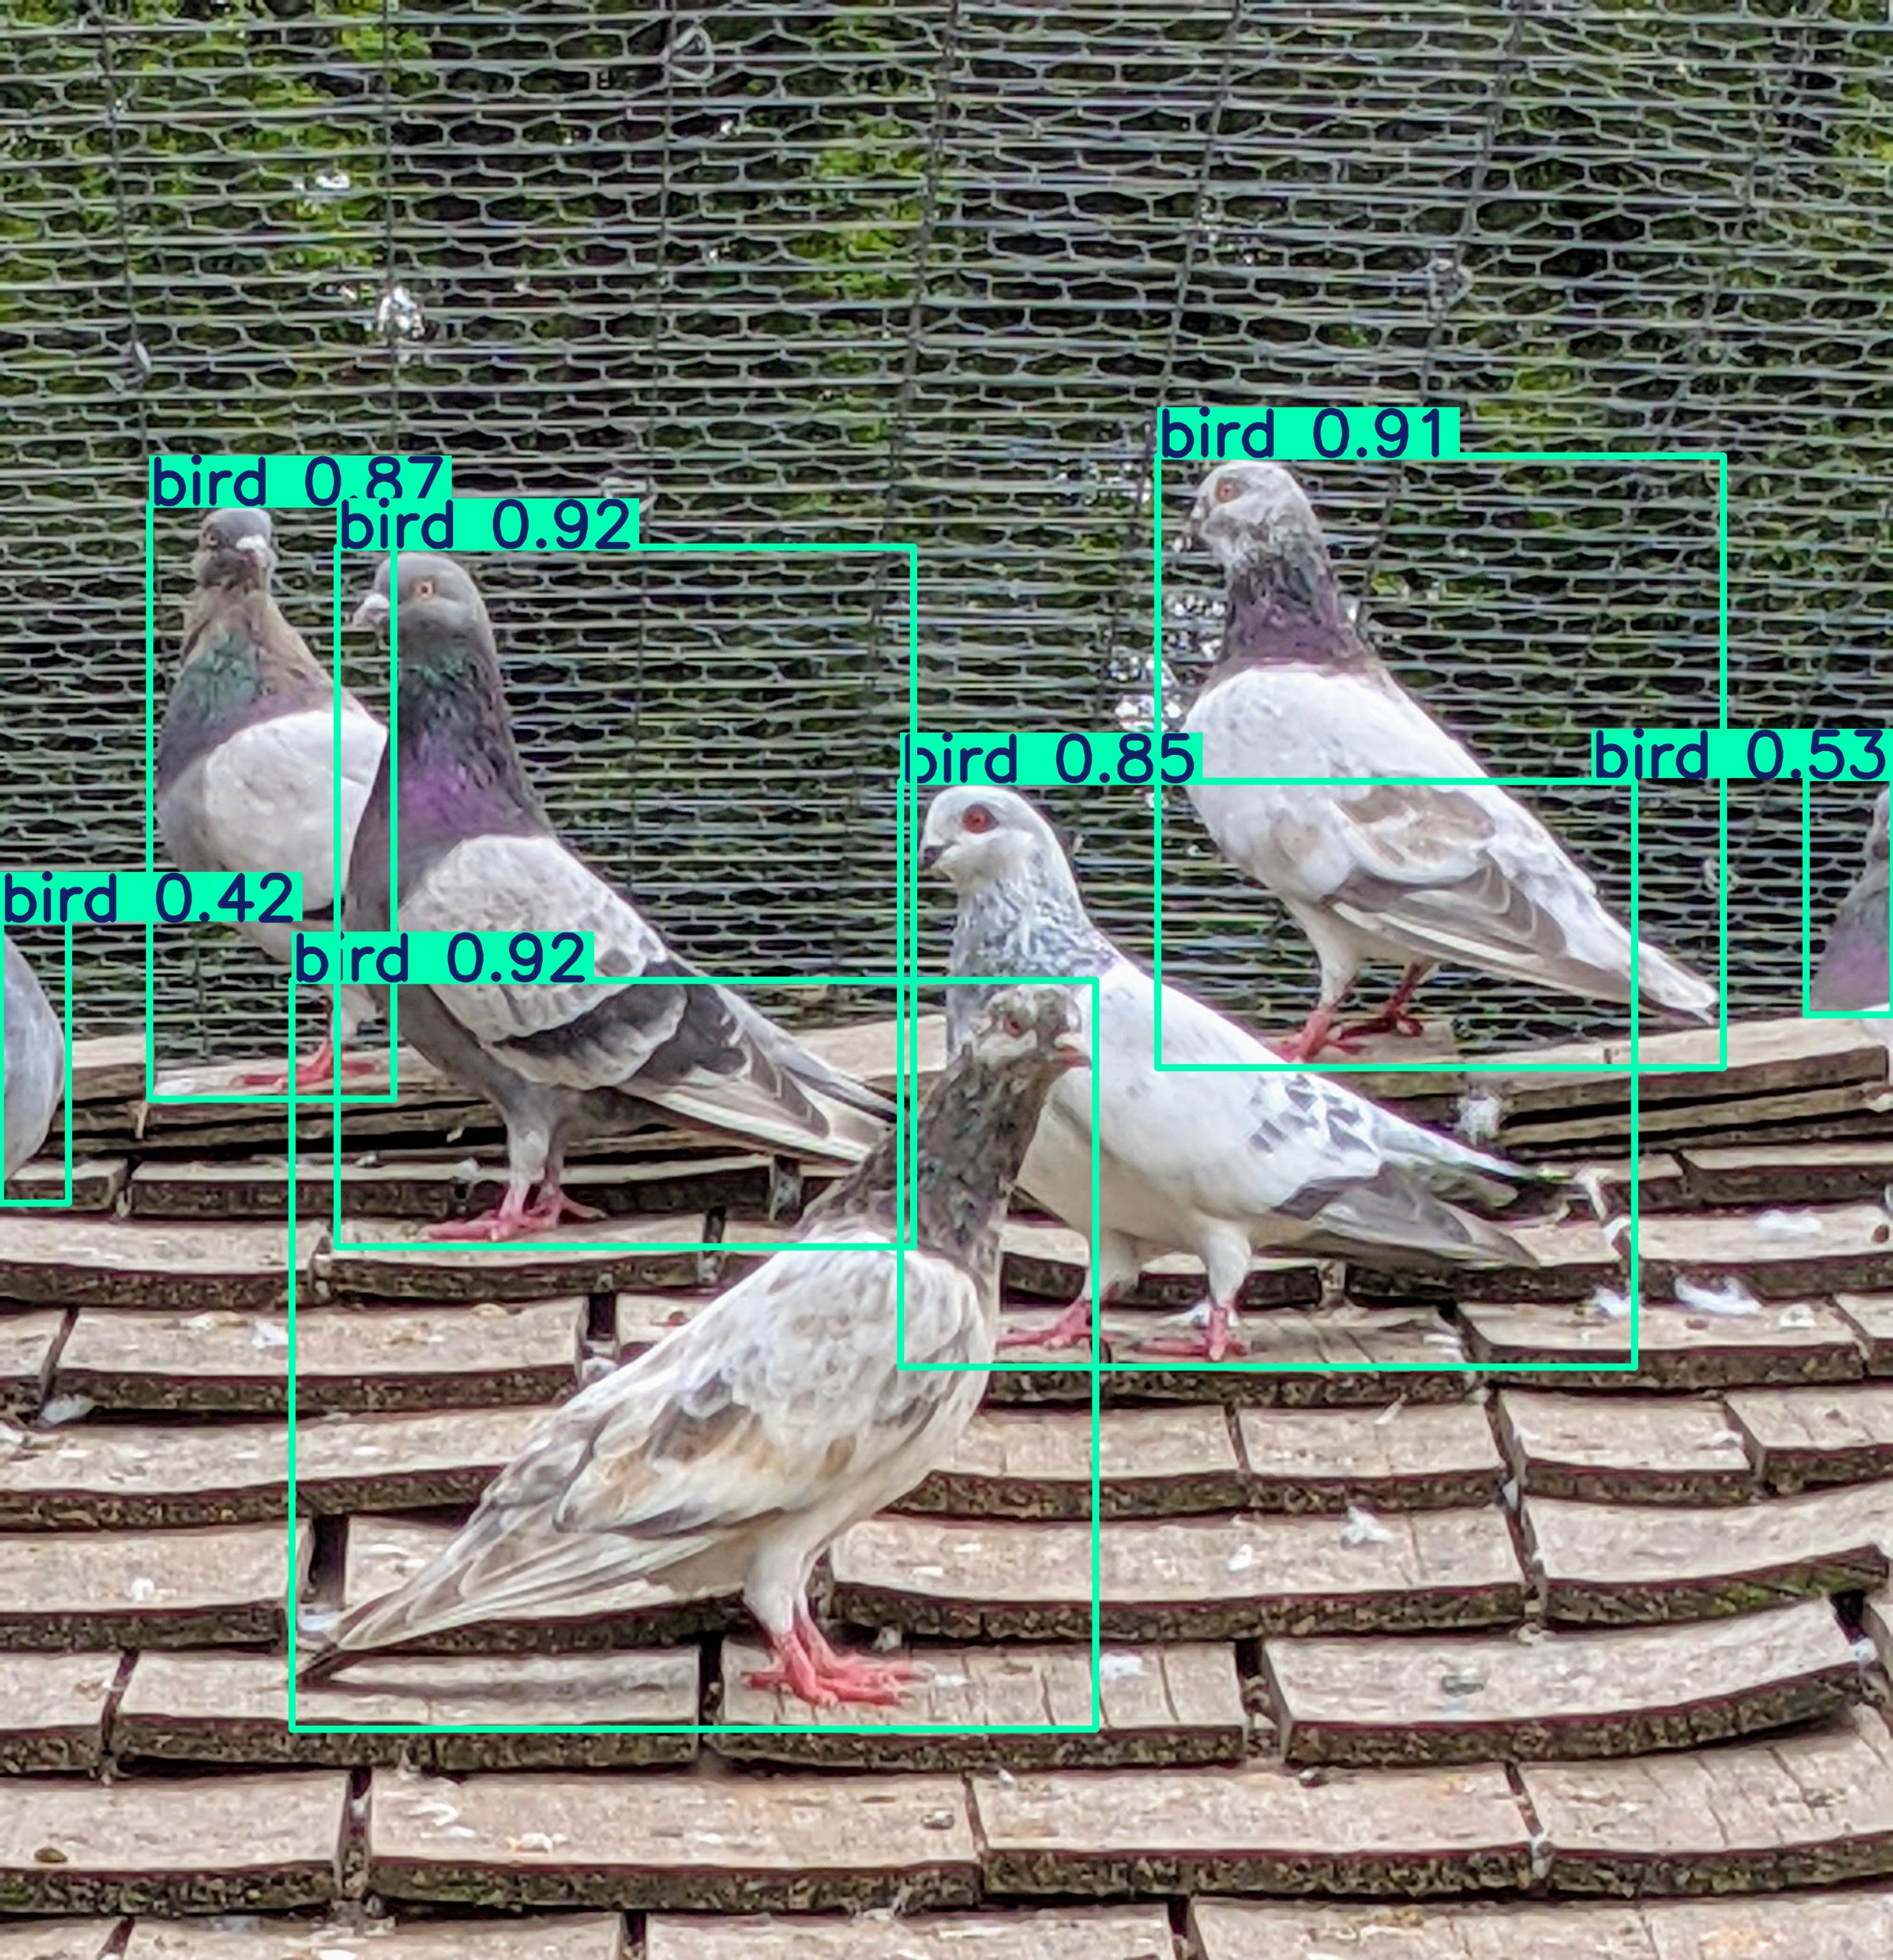

In [6]:
from IPython.display import Image as IPyImage
import os

IPyImage(filename=os.path.join(PREDICTED_FOLDER, predicted_file_name), width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [7]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://static.themarthablog.com/2021/08/PXL_20210809_185425726-scaled.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]


0: 640x640 7 birds, 8.1ms
Speed: 7.4ms preprocess, 8.1ms inference, 616.7ms postprocess per image at shape (1, 3, 640, 640)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [8]:
result.boxes.xyxy

tensor([[4.4050e+02, 7.1452e+02, 1.1936e+03, 1.6281e+03],
        [3.8150e+02, 1.2800e+03, 1.4317e+03, 2.2582e+03],
        [1.5120e+03, 5.9529e+02, 2.2511e+03, 1.3948e+03],
        [1.9514e+02, 6.5900e+02, 5.1457e+02, 1.4354e+03],
        [1.1769e+03, 1.0209e+03, 2.1354e+03, 1.7858e+03],
        [2.3591e+03, 1.0159e+03, 2.4730e+03, 1.3257e+03],
        [9.9308e-01, 1.2022e+03, 8.9583e+01, 1.5717e+03]], device='cuda:0')

In [9]:
result.boxes.conf

tensor([0.9233, 0.9168, 0.9113, 0.8687, 0.8519, 0.5305, 0.4172], device='cuda:0')

In [10]:
result.boxes.cls

tensor([14., 14., 14., 14., 14., 14., 14.], device='cuda:0')

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [11]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

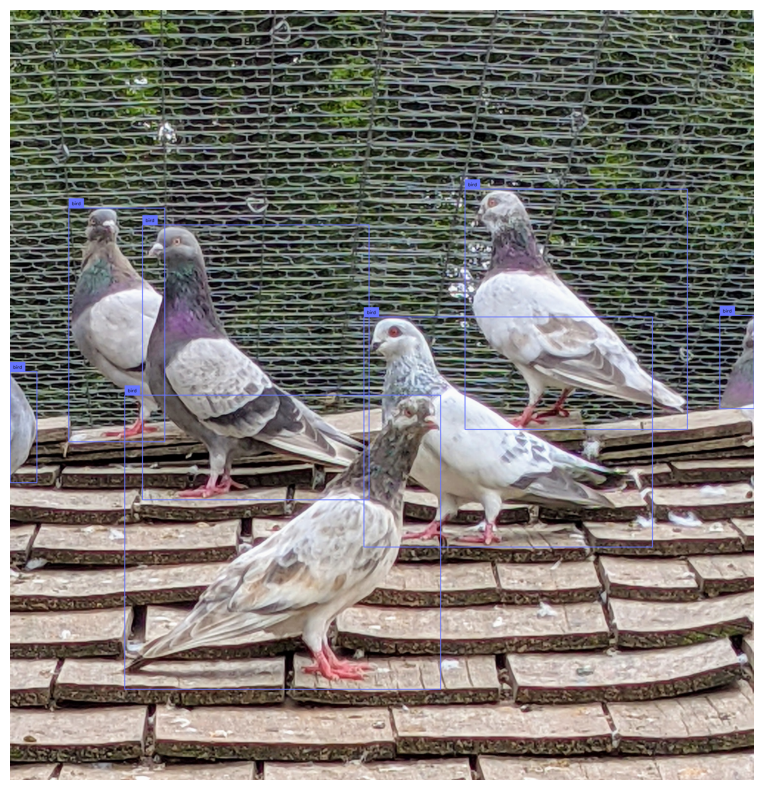

In [12]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [14]:
!rm -rf {HOME}/datasets
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

workspace = rf.workspace("myplayspace")
project = workspace.project("pigeon-hunter")
version = project.version(2)
dataset = version.download("yolov11")

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pigeon-Hunter-2 in yolov11:: 100%|██████████| 9366/9366 [00:05<00:00, 1713.24it/s]


## Custom Training

In [15]:
print(dataset.location)  # verify the dataset path

/content/datasets/Pigeon-Hunter-2


In [16]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 233MB/s]
New https://pypi.org/project/ultralytics/8.3.63 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/Pigeon-Hunter-2/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, clas

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [17]:
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			    R_curve.png		   val_batch1_labels.jpg
confusion_matrix.png				    results.csv		   val_batch1_pred.jpg
events.out.tfevents.1737302040.3a4f869e22c6.1214.0  results.png		   val_batch2_labels.jpg
F1_curve.png					    train_batch0.jpg	   val_batch2_pred.jpg
labels_correlogram.jpg				    train_batch1.jpg	   weights
labels.jpg					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


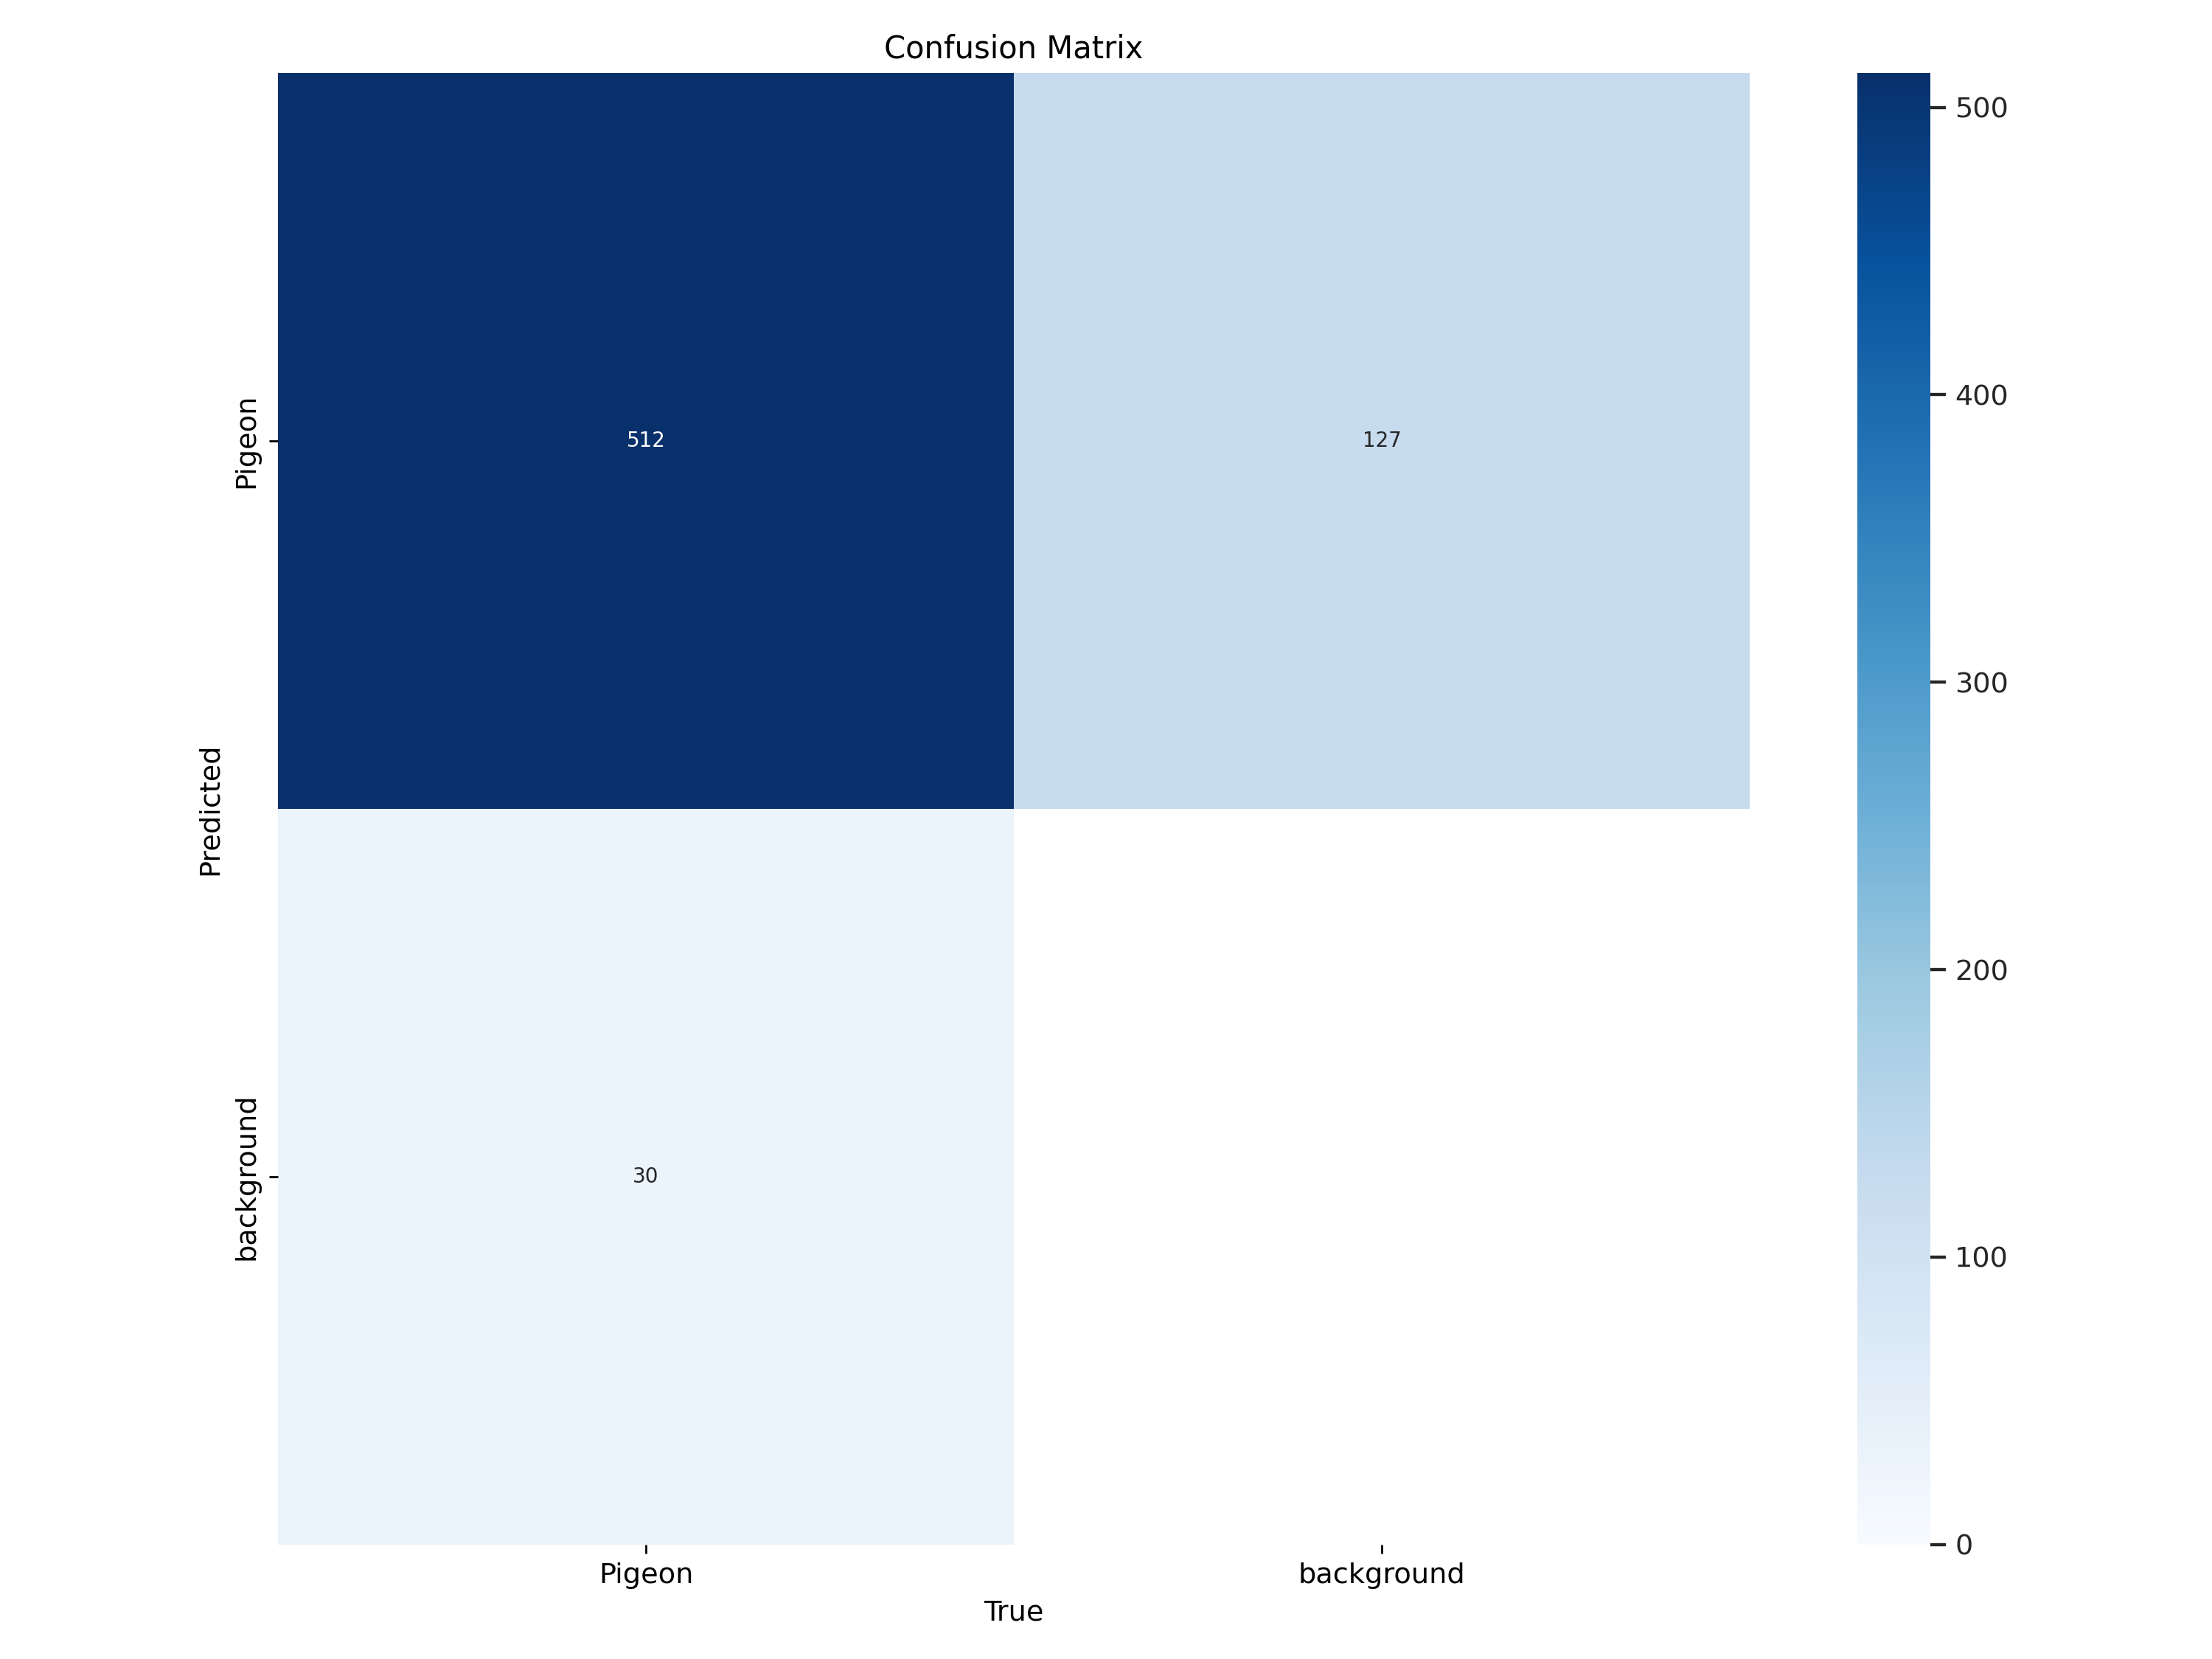

In [18]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

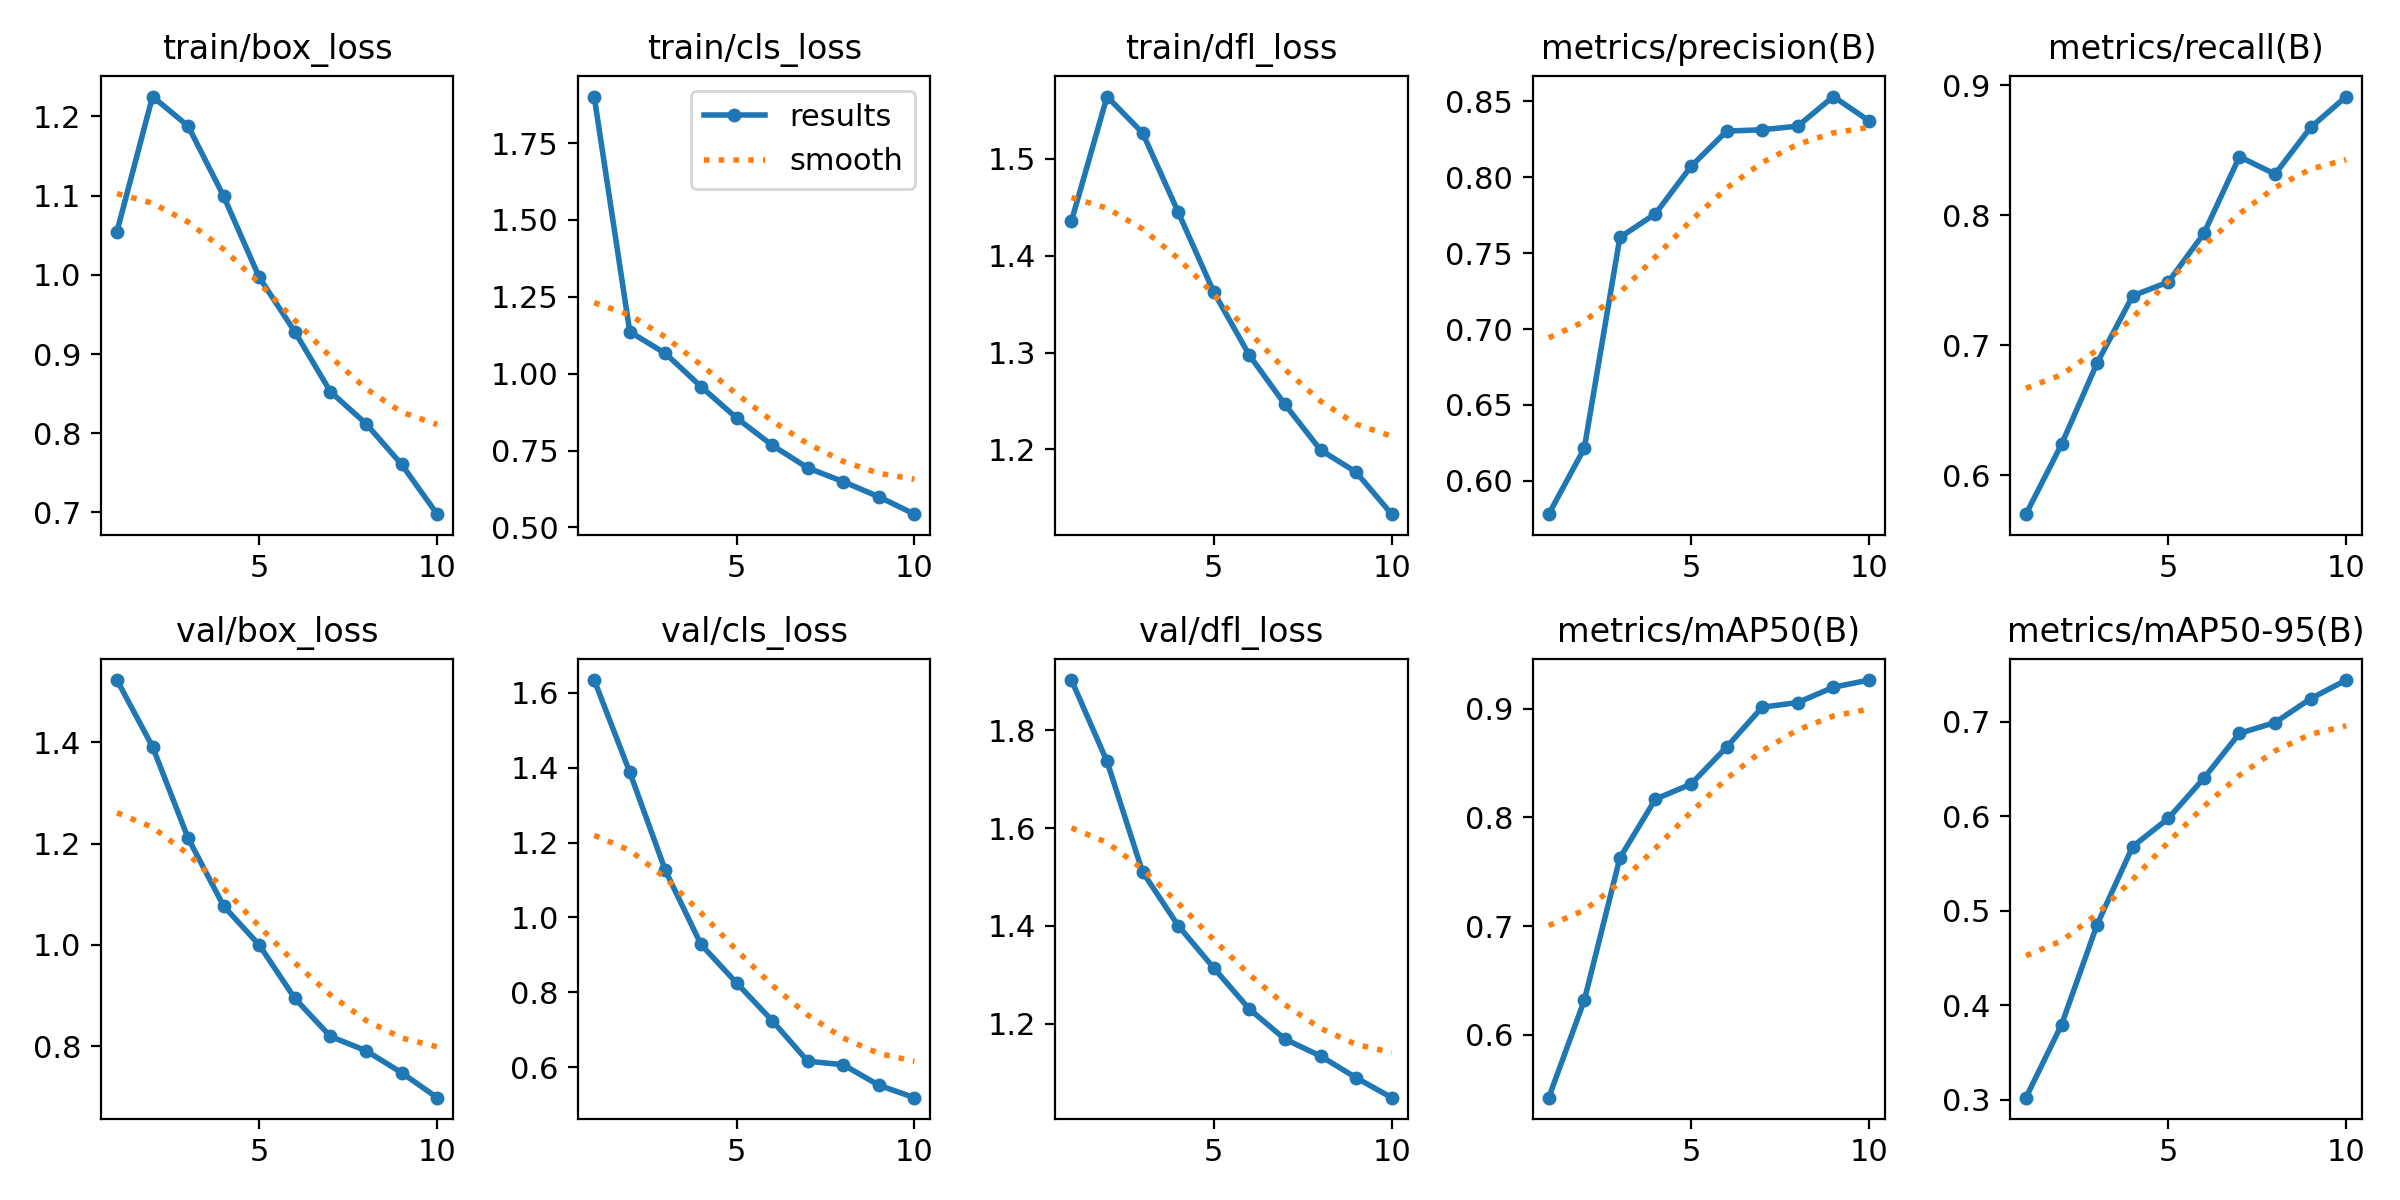

In [19]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

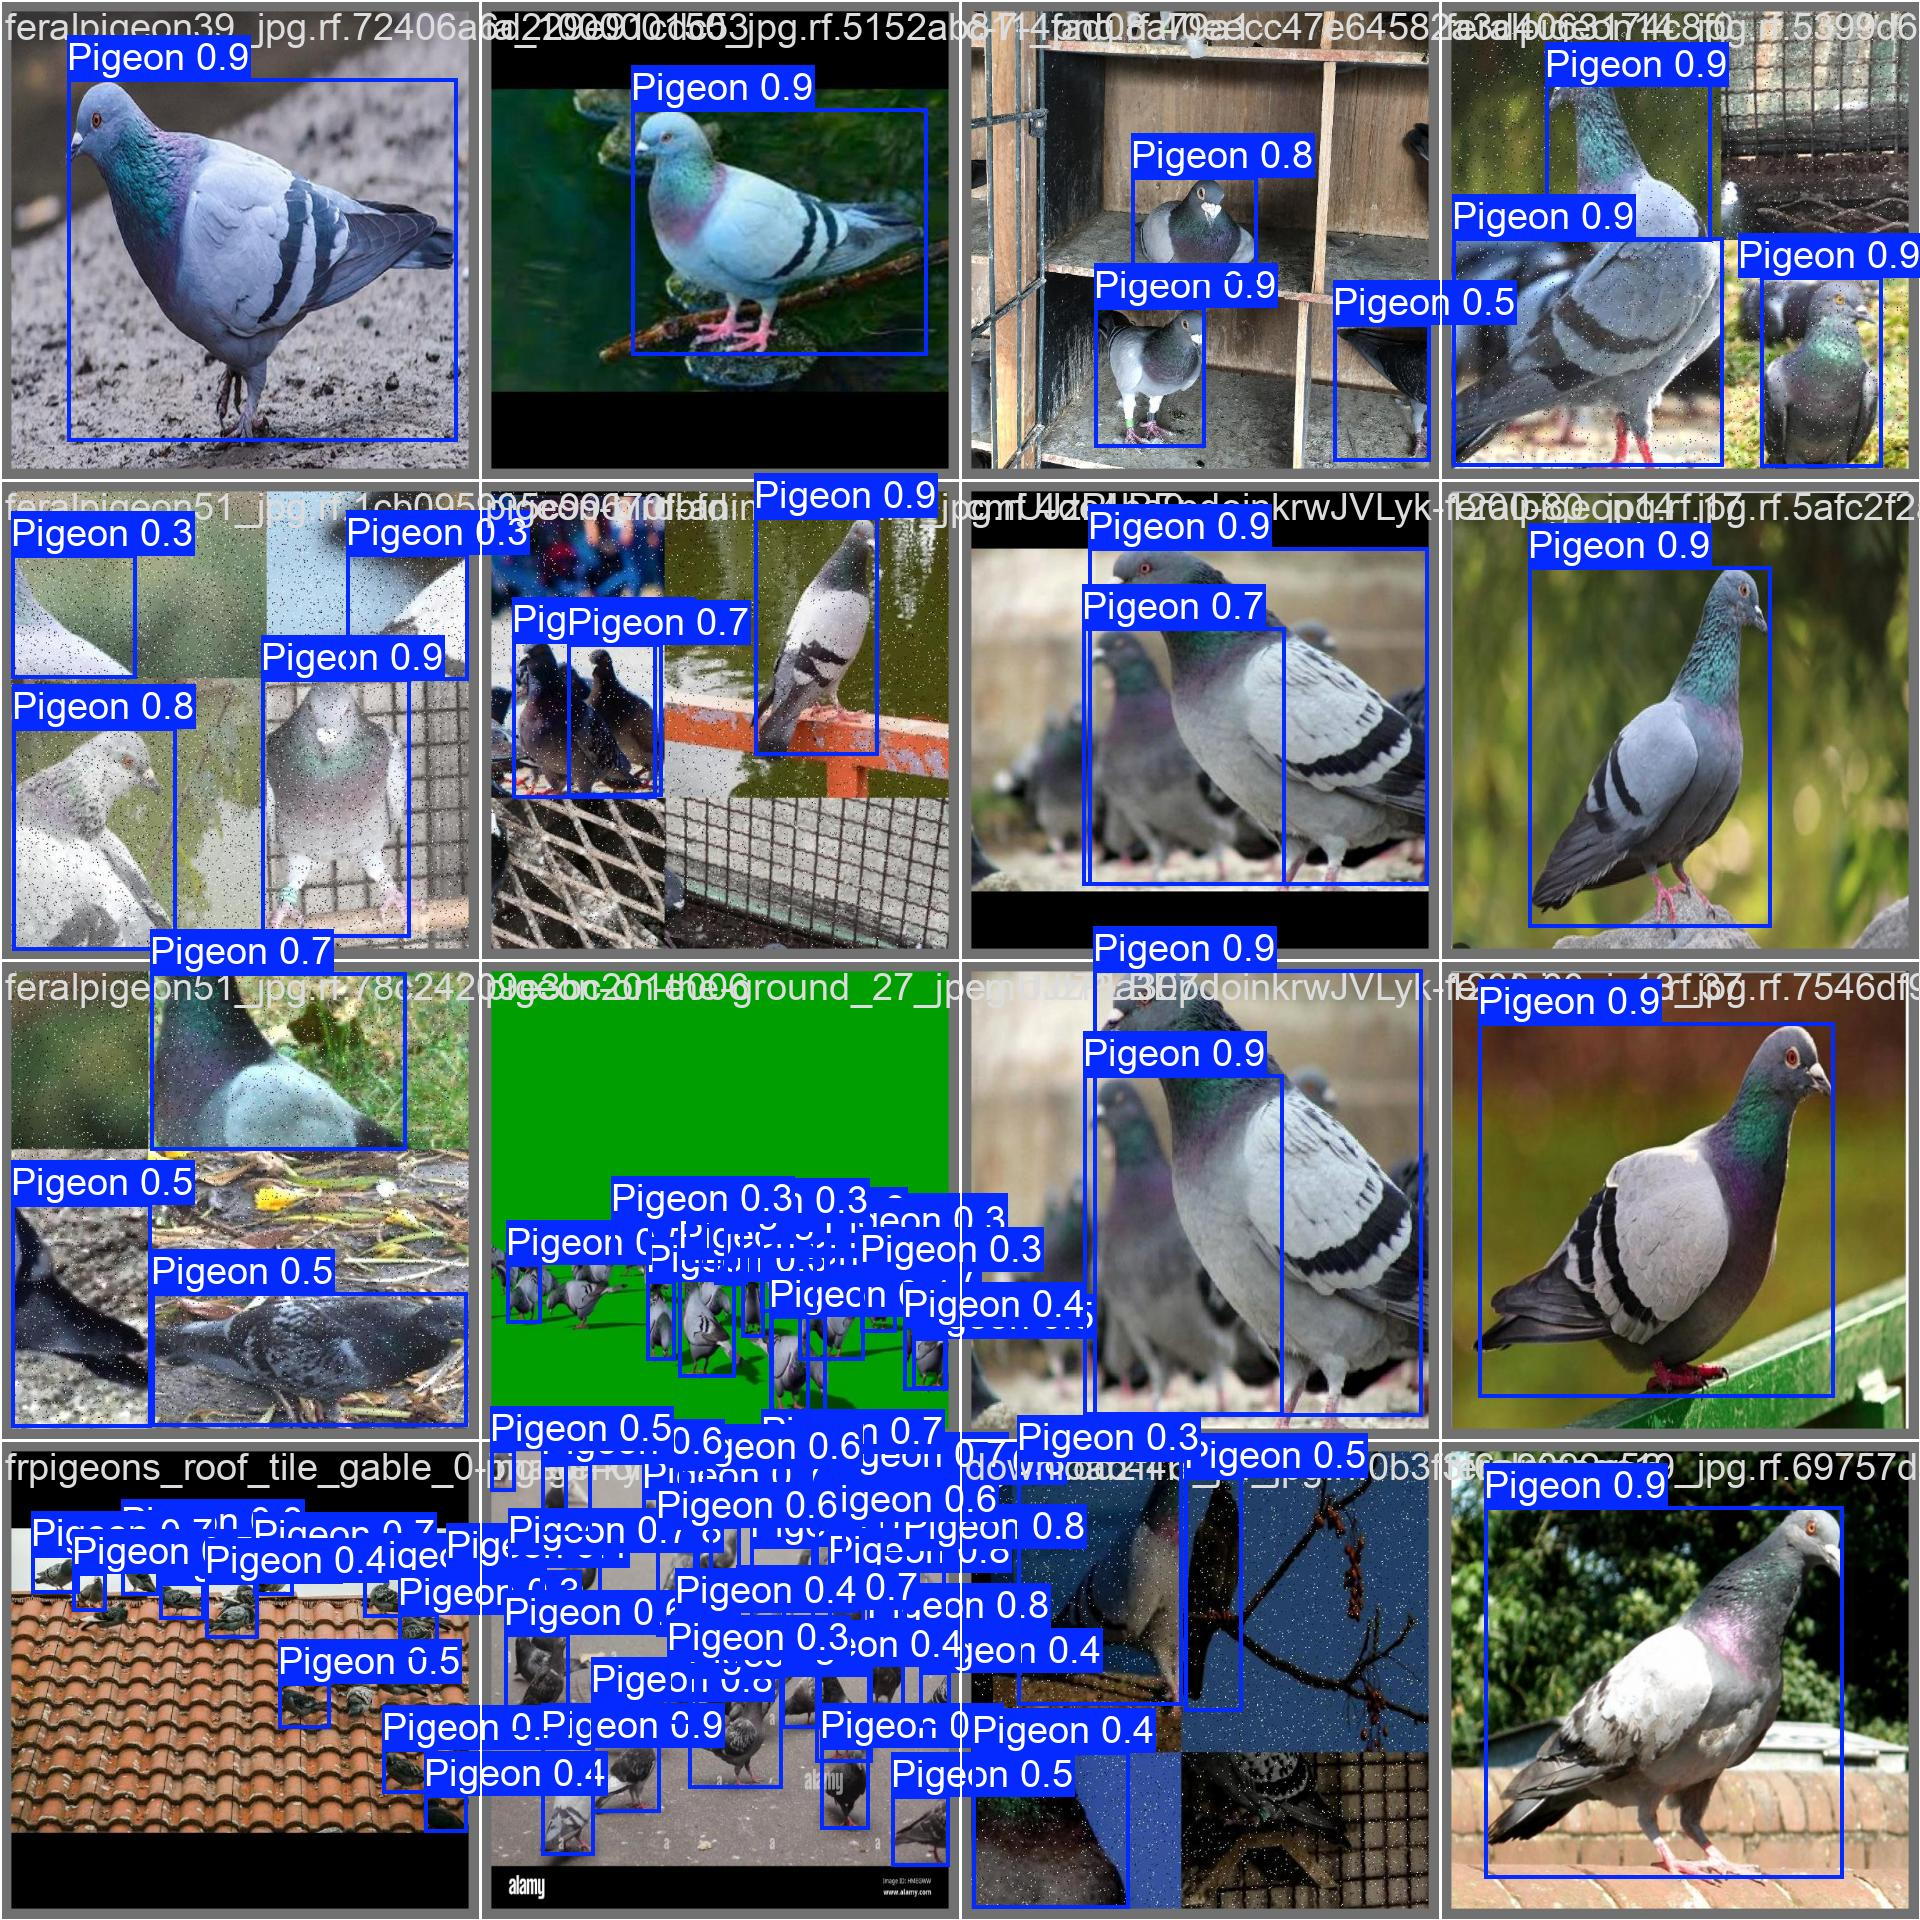

In [20]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [21]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/Pigeon-Hunter-2/valid/labels.cache... 276 images, 0 backgrounds, 0 corrupt: 100% 276/276 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 18/18 [00:05<00:00,  3.03it/s]
                   all        276        542       0.83      0.899      0.927      0.743
Speed: 2.2ms preprocess, 9.5ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference with custom model

In [22]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/515 /content/datasets/Pigeon-Hunter-2/test/images/002_jpg.rf.4eb3a6d9252920faea67588a8531907e.jpg: 640x640 1 Pigeon, 15.6ms
image 2/515 /content/datasets/Pigeon-Hunter-2/test/images/003_jpg.rf.6ade10cce458f47d3e9999d2e2df247f.jpg: 640x640 1 Pigeon, 15.6ms
image 3/515 /content/datasets/Pigeon-Hunter-2/test/images/003_jpg.rf.b8074fa3e4b12e27a2fb527ec2c95137.jpg: 640x640 1 Pigeon, 15.6ms
image 4/515 /content/datasets/Pigeon-Hunter-2/test/images/004_jpg.rf.55c1c5550279323fd8bb5e83792de77a.jpg: 640x640 1 Pigeon, 15.5ms
image 5/515 /content/datasets/Pigeon-Hunter-2/test/images/004_jpg.rf.9a1cae665ae50fa4633201b782f6c8af.jpg: 640x640 1 Pigeon, 15.5ms
image 6/515 /content/datasets/Pigeon-Hunter-2/test/images/009_jpg.rf.eb35d9bc25383d4382c1446a55a76b56.jpg: 640x640 1 Pigeon, 15.5ms
image 7/515 /content/datasets/Pigeon-Hunt

**NOTE:** Let's take a look at few results.

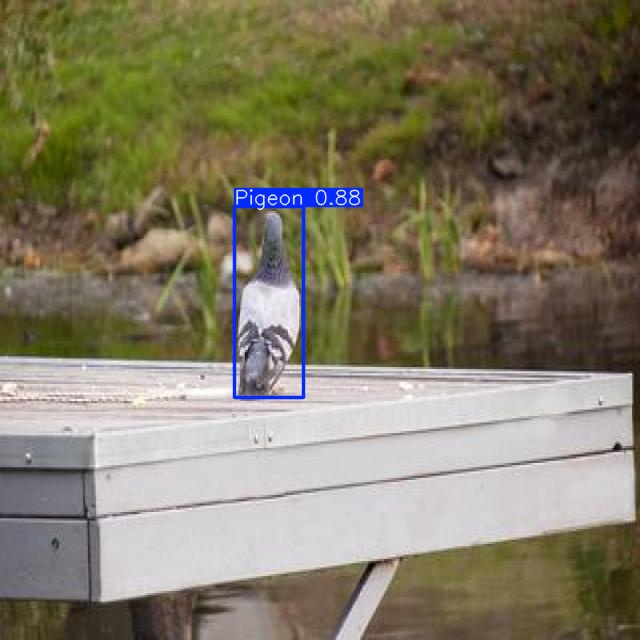

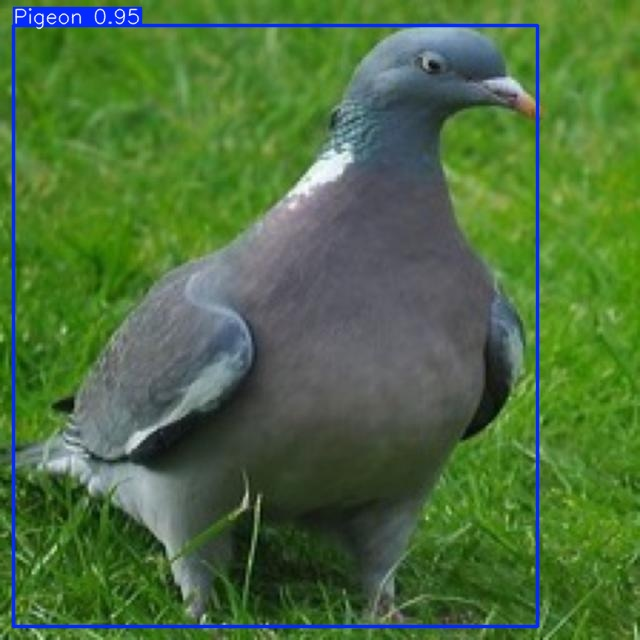

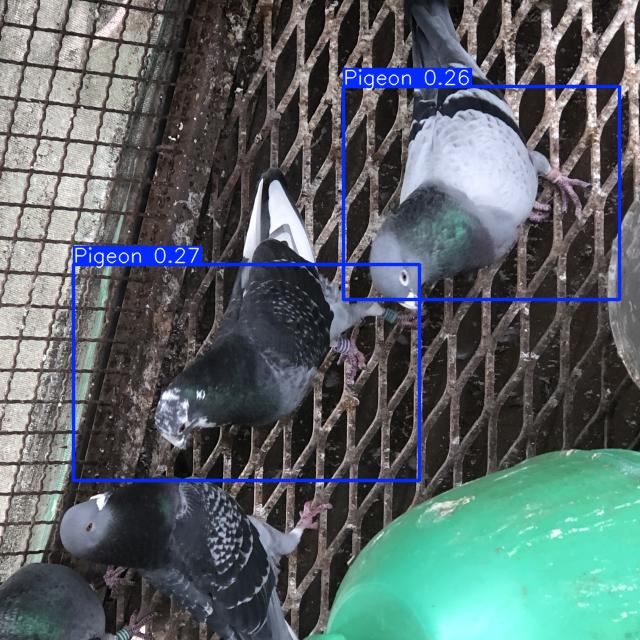

In [23]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

In [1]:
!cd {HOME}
%ls

/bin/bash: line 1: cd: {HOME}: No such file or directory
datasets/  PXL_20210809_185425726-scaled.jpeg  runs/  yolo11n.pt  yolo11s.pt  yolov5/


In [1]:
# Clone the YOLOv5 repository
!cd {HOME}
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

# Install dependencies
!pip install -r requirements.txt


/bin/bash: line 1: cd: {HOME}: No such file or directory
fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.1 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.13.1 which is incompatible.
pymc 5.19.1 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.


In [3]:
!pip install tensorflow==2.13.1

  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydantic-core 2.27.2 requires typing-extensions!=4.7.0,>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
openai 1.59.6 requires typing-extensions<5,>=4.11, but you have typing-extensions 4.5.0 which is incompatible.
sqlalchemy 2.0.37 requires typing-extensions>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
typeguard 4.4.1 requires typing-extensions>=4.10.0, but you have typing-extensions 4.5.0 which is incompatible.
tf-keras 2.17.0 requires tenso

In [4]:
import os
HOME = '/content'
%cd {HOME}
#%cd yolov5
%ls
%cd yolov5
%ls
#!python export.py --weights {HOME}/runs/detect/train/weights/best.pt --img-size 640 --batch-size 1 --include onnx tflite --simplify
!python export.py --weights /content/runs/detect/train/weights/best.pt --include onnx

/content
datasets/  PXL_20210809_185425726-scaled.jpeg  runs/  yolo11n.pt  yolo11s.pt  yolov5/
/content/yolov5
benchmarks.py    data/       LICENSE         README.zh-CN.md   tutorial.ipynb
CITATION.cff     detect.py   models/         requirements.txt  utils/
classify/        export.py   pyproject.toml  segment/          val.py
CONTRIBUTING.md  hubconf.py  README.md       train.py
export: data=data/coco128.yaml, weights=['/content/runs/detect/train/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, per_tensor=False, dynamic=False, cache=, simplify=False, mlmodel=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx', 'tflite']
YOLOv5 🚀 v7.0-397-gde62f93c Python-3.11.11 torch-2.5.1+cu121 CPU

YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

PyTorch: starting from /content

In [5]:
!pip install onnx onnx-tf


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 28.8 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [9]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.13.0
    Uninstalling tensorboard-2.13.0:
      Successfully uninstalled tensorboard-2.13.0
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.13.1
    Uninstalling tensorflow-2.13.1:
      S

In [8]:
from onnx_tf.backend import prepare
import onnx
import tensorflow as tf

# Load ONNX model
onnx_model = onnx.load('/content/runs/detect/train/weights/best.onnx')

# Convert to TensorFlow
tf_rep = prepare(onnx_model)
tf_rep.export_graph('/content/runs/detect/train/weights/best_saved_model')


ImportError: This version of TensorFlow Probability requires TensorFlow version >= 2.16; Detected an installation of version 2.13.1. Please upgrade TensorFlow to proceed.

## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [ ]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

In [ ]:
!pip install inference

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get('ROBOFLOW_API_KEY'))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.